In [2]:
import os
import glob
import utils.utils as utils
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

CONF_THRESHOLD = 0.2

# IoU_threshold = 0.5
# IoU_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.63, 0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9, 0.93, 0.96]
#IoU_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.63, 0.66, 0.69, 0.72, 0.75]
IoU_thresholds = np.linspace(0.1, 0.71, 36, dtype=np.float64)


DATASETS_PATH = "/home/umut/Desktop/TEST_EXPERIMENTS/hist_eq_filtered_variations/not_filtered_random_datasets/datasets"

TEST_OR_VAL = "test"

In [3]:
#create dictionary object to create pandas dataframe
data = {
    "Dataset_Name" : [],
    "Test_or_Val": [],
    "IoU_Threshold": [],
    "Recall": [],
    "Precision": [],
    "F1_Score": [],
    "True_Positive_Count": [],
    "False_Positive_Count": [],
    "False_Negative_Count": []
}

#create the empty dataframe
df = pd.DataFrame(data)


dataset_names = sorted(os.listdir(DATASETS_PATH))

dataset_count = len(dataset_names)

for (dataset_num, current_dataset) in enumerate(dataset_names):
    
    #create dictionary object to create pandas dataframe for current dataset
    current_data = {
    "Dataset_Name" : [],
    "Test_or_Val": [],
    "IoU_Threshold": [],
    "Recall": [],
    "Precision": [],
    "F1_Score": [],
    "True_Positive_Count": [],
    "False_Positive_Count": [],
    "False_Negative_Count": []
    }


    #Determine the paths
    current_dataset_path = os.path.join(DATASETS_PATH, current_dataset)

    MODEL_PATH = os.path.join(current_dataset_path, "best.pt")

    IMAGES_PATH = os.path.join(current_dataset_path, TEST_OR_VAL, "images")

    LABELS_PATH = os.path.join(current_dataset_path, TEST_OR_VAL, "labels")

    #load the model
    model = YOLO(MODEL_PATH)

    #get the results
    results = model.predict(IMAGES_PATH, verbose=False, conf=CONF_THRESHOLD)

    # get prediction results
    predictions_xyxy_normalized = [(result.boxes.xyxyn.to("cpu")) for result in results]

    #get label paths
    label_paths = [os.path.join(LABELS_PATH, (os.path.splitext(os.path.basename(result.path))[0] + ".txt")) for result in results]


    #get label bboxes
    label_bboxes = [utils.get_xyxy_bboxes_from_YOLO_format_txt(label_path) for label_path in label_paths]


    for IoU_threshold in IoU_thresholds:

        #calculate the TP, FP and FN for images
        TP, FP, FN = utils.calculate_TP_FP_FN_all_images(predictions_xyxy_normalized, label_bboxes, IoU_threshold=IoU_threshold)

        #calculate the recall and precision for images
        recall, precision = utils.calculate_recall_and_precision_from_TP_FP_FN(TP, FP, FN)

        #calculate F1 score for images
        f1_score = utils.get_F1_score_from_recall_and_precision(recall, precision)

        
        # add values to current_data dictionary
        current_data["Dataset_Name"].append(current_dataset)
        current_data["Test_or_Val"].append(TEST_OR_VAL)
        current_data["IoU_Threshold"].append(IoU_threshold)
        current_data["Recall"].append(recall)
        current_data["Precision"].append(precision)
        current_data["F1_Score"].append(f1_score)
        current_data["True_Positive_Count"].append(TP)
        current_data["False_Positive_Count"].append(FP)
        current_data["False_Negative_Count"].append(FN)
        

    #create the dataframe for current dataset
    current_df = pd.DataFrame(current_data)
    
    #merge the current_data dictionary to data dictionary
    df = pd.concat([df, current_df], ignore_index=True)

    #print the current status
    print(f"{dataset_num+1}/{dataset_count} datasets are processed")

print(df)

1/10 datasets are processed
2/10 datasets are processed
3/10 datasets are processed
4/10 datasets are processed
5/10 datasets are processed
6/10 datasets are processed
7/10 datasets are processed
8/10 datasets are processed
9/10 datasets are processed
10/10 datasets are processed
               Dataset_Name Test_or_Val  IoU_Threshold    Recall  Precision  \
0    not_filtered_dataset_0        test       0.100000  0.960245   0.915452   
1    not_filtered_dataset_0        test       0.117429  0.960245   0.915452   
2    not_filtered_dataset_0        test       0.134857  0.960245   0.915452   
3    not_filtered_dataset_0        test       0.152286  0.960245   0.915452   
4    not_filtered_dataset_0        test       0.169714  0.960245   0.915452   
..                      ...         ...            ...       ...        ...   
355  not_filtered_dataset_9        test       0.640286  0.873171   0.848341   
356  not_filtered_dataset_9        test       0.657714  0.858537   0.834123   
357  not

In [4]:
# Get the mean of the dataframe, saving IoU threshold column deleting the Dataset_Name column
df_mean = (df.drop(columns=["Dataset_Name", "Test_or_Val"])).groupby(["IoU_Threshold"]).mean().reset_index()

print(df_mean)

    IoU_Threshold    Recall  Precision  F1_Score  True_Positive_Count  \
0        0.100000  0.974766   0.921159  0.947057                332.3   
1        0.117429  0.974462   0.920871  0.946761                332.2   
2        0.134857  0.974462   0.920871  0.946761                332.2   
3        0.152286  0.974155   0.920569  0.946456                332.1   
4        0.169714  0.974155   0.920569  0.946456                332.1   
5        0.187143  0.974155   0.920569  0.946456                332.1   
6        0.204571  0.974155   0.920569  0.946456                332.1   
7        0.222000  0.973545   0.919993  0.945864                331.9   
8        0.239429  0.973545   0.919993  0.945864                331.9   
9        0.256857  0.973267   0.919733  0.945595                331.8   
10       0.274286  0.973023   0.919496  0.945355                331.7   
11       0.291714  0.973023   0.919496  0.945355                331.7   
12       0.309143  0.972718   0.919208  0.945059   

In [6]:
#save the dataframe as csv
df_mean.to_csv("not_filtered_recall_precision_F1_score_TP_FP_FN.csv", index=False)

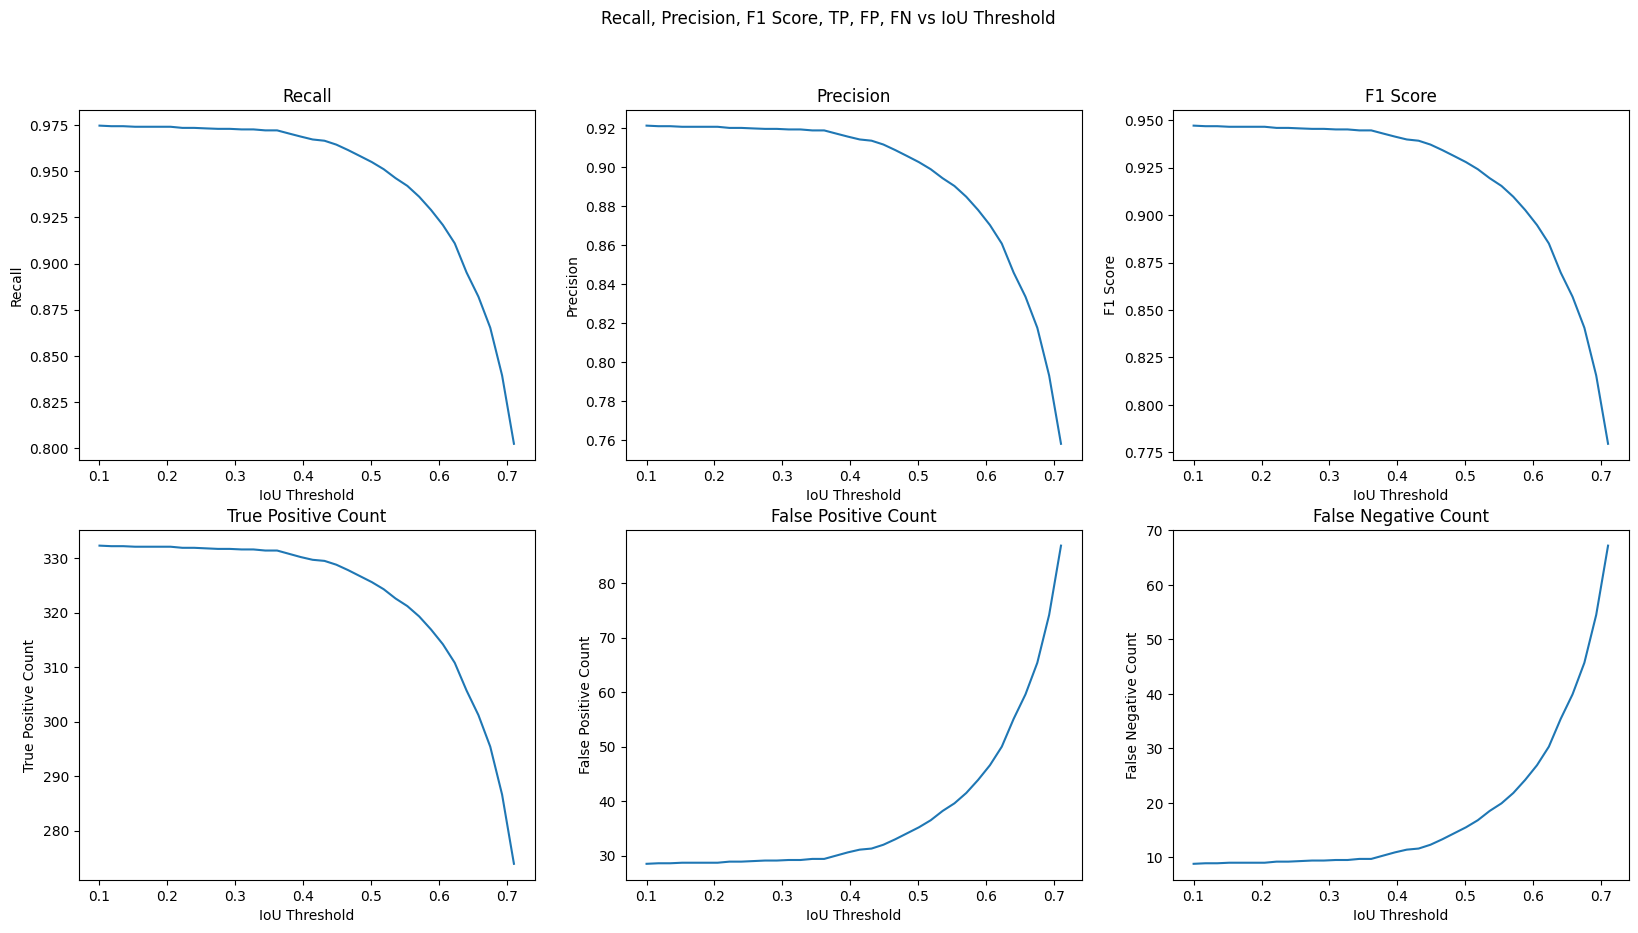

In [7]:
## VISIULATION PART

#plot 6 graphs as 2x3 for recall, precision and F1 score as subplots, TP, FP, FN. Also name the x and y axes and add title
fig, axs = plt.subplots(2,3, figsize=(20, 10))
fig.suptitle('Recall, Precision, F1 Score, TP, FP, FN vs IoU Threshold')

axs[0,0].plot(df_mean["IoU_Threshold"], df_mean["Recall"])
axs[0,0].set_title("Recall")
axs[0,0].set_xlabel("IoU Threshold")
axs[0,0].set_ylabel("Recall")

axs[0,1].plot(df_mean["IoU_Threshold"], df_mean["Precision"])
axs[0,1].set_title("Precision")
axs[0,1].set_xlabel("IoU Threshold")
axs[0,1].set_ylabel("Precision")

axs[0,2].plot(df_mean["IoU_Threshold"], df_mean["F1_Score"])
axs[0,2].set_title("F1 Score")
axs[0,2].set_xlabel("IoU Threshold")
axs[0,2].set_ylabel("F1 Score")

axs[1,0].plot(df_mean["IoU_Threshold"], df_mean["True_Positive_Count"])
axs[1,0].set_title("True Positive Count")
axs[1,0].set_xlabel("IoU Threshold")
axs[1,0].set_ylabel("True Positive Count")

axs[1,1].plot(df_mean["IoU_Threshold"], df_mean["False_Positive_Count"])
axs[1,1].set_title("False Positive Count")
axs[1,1].set_xlabel("IoU Threshold")
axs[1,1].set_ylabel("False Positive Count")

axs[1,2].plot(df_mean["IoU_Threshold"], df_mean["False_Negative_Count"])
axs[1,2].set_title("False Negative Count")
axs[1,2].set_xlabel("IoU Threshold")
axs[1,2].set_ylabel("False Negative Count")

plt.savefig("csv_files/png_files/not_filtered_recall_precision_F1_score_TP_FP_FN.png")

plt.show()